In [60]:
import pandas as pd
from scipy.constants import h, k as k_B
from physics.mkid import model

# Model

In [92]:
volume_multiplier = 9
nominal_skip_volume_um3 = 1870

kid = model.KID(active_metal=model.Aluminum(T_c=1.39),
                active_volume_um3=volume_multiplier * nominal_skip_volume_um3,
                inactive_metal=None,
                inactive_volume_um3=0,
                substrate=model.Substrate(T=0.12),
                phonon_trapping_factor=1,
                alpha=0.4,
                f_r=164e6,
                iQc=20e-6,
                iQi0=2e-6,
                S_TLS_at_P_c=1e-17 / 1000**(1/2),  # Use the approximate value at 1 kHz
                P_c=1.3e-15)  # From dark measurements

In [93]:
# Optical system and environment

# Optical bandwidth, in Hz, for the source output
#bandwidth = (160 - 140) * 1e9
# From the analysis
bandwidth = 13e9

# Broadband center frequency, in Hz
nu_center = 150e9

# Background absorbed power, in W
P_B = 0.08e-12

# System optical efficiency (not implemented yet)
eta = 1

# Absorbed power, in W
P_A = np.logspace(-14.9, -10.4, 1e4)
Gamma_A = kid.optical_generation_rate(P_A, nu_center)
Gamma_B = kid.optical_generation_rate(P_B, nu_center)

# Readout parameters

# Amplifier noise temperature, in K
T_amp = 4

# Readout power in W
P_g = 2e-13

# Derived constants
print("\\Delta = {:.0f} ueV".format(1e6 * kid.active_metal.Delta_eV))

# Gap frequency
print("\\nu_g = {:.1f} GHz".format(1e-9 * kid.active_metal.nu_gap))

# Recombination constant
print("R = {:.1f} um^3 s^-1".format(kid.active_metal.R_um3_per_s))

# Effective recombination constant
print("R_* = {:.1f} um^3 s^-1".format(kid.effective_recombination_um3_per_s))

\Delta = 211 ueV
\nu_g = 102.2 GHz
R = 6.9 um^3 s^-1
R_* = 6.9 um^3 s^-1


In [94]:
print("m_center = {:.2f}".format(kid.active_metal.quasiparticles_per_photon(nu_center)))
print("{:.2g} s^-1 <= Gamma_A <= {:.2g} s^-1".format(Gamma_A[0], Gamma_A[-1]))
print("Gamma_B = {:.2g} s^-1".format(Gamma_B))
print("Gamma_t = {:.2g} s^-1".format(kid.thermal_generation_rate()))
Gamma = Gamma_A + Gamma_B + kid.thermal_generation_rate()

m_center = 2.00
2.5e+07 s^-1 <= Gamma_A <= 8e+11 s^-1
Gamma_B = 1.6e+09 s^-1
Gamma_t = 3.4 s^-1


In [95]:
photon = (kid.NEP2_photon(Gamma=Gamma_A, nu=nu_center, bandwidth=bandwidth) +
          kid.NEP2_photon(Gamma=Gamma_B, nu=nu_center, bandwidth=bandwidth))
recombination = kid.NEP2_recombination(Gamma=Gamma, nu=nu_center)
amplifier = kid.NEP2_amp(T_amp=T_amp, P_g=P_g, Gamma=Gamma, nu=nu_center)
TLS = kid.NEP2_TLS(P_g=P_g, Gamma=Gamma, nu=nu_center)
device = photon + recombination + TLS
total = photon + recombination + amplifier + TLS

# Data

In [96]:
cw = pd.DataFrame(np.load('../15/continuous-wave.npy'))
bb = pd.DataFrame(np.load('../15/broadband.npy'))

In [97]:
cw_max_name = 'cw20_ampfreebincut10prop'
cw_max_file = '2015-12-22_fitlogbin/cw1220/{}.h5'.format(cw_max_name)
cw_max_short = 'afbc10p'
bb_max_name = 'bb20_ampfreebincut10prop'
bb_max_file = '2015-12-22_fitlogbin/bb1220/{}.h5'.format(bb_max_name)
bb_max_short = 'afbc10p'
off_max_name = 'dark_ampfree_alphafix_bincut10prop'
off_max_file = '2015-12-22_fitlogbin/dark/{}.h5'.format(off_max_name)
off_max_short = 'afaxbc10p'

In [98]:
cw_NEP2_key = 'source_power_fd_{}_NEP2_device'.format(cw_max_short)
#cw_NEP2_amp_key = 'source_power_fd_{}_NEP2_amp'.format(cw_max_short)
bb_NEP2_key = 'source_power_fd_{}_NEP2_device'.format(bb_max_short)
#bb_NEP2_amp_key = 'source_power_fd_{}_NEP2_amp'.format(bb_max_short)

In [99]:
bb['d_S21_d_X'] = bb.chi_c * bb.chi_g / (2 * bb.source_power_I)
bb['d_S21_d_I'] = bb.chi_c * bb.chi_g / (4 * bb.source_power_I)

In [100]:
cw['d_S21_d_X'] = cw.chi_c * cw.chi_g / (2 * cw.source_power_I)
cw['d_S21_d_I'] = cw.chi_c * cw.chi_g / (4 * cw.source_power_I)

In [101]:
NEP_cw = cw.eta * cw[cw_NEP2_key]**(1/2)
NEP_cw_err = NEP_cw * (1/2) * (cw[cw_NEP2_key + '_err'] / cw[cw_NEP2_key])
#NEP_cw_amp = cw.eta * cw[cw_NEP2_amp_key]**(1/2)
#NEP_cw_amp_err = NEP_cw * (1/2) * (cw[cw_NEP2_amp_key + '_err'] / cw[cw_NEP2_amp_key])

NEP_bb = bb.eta * bb[bb_NEP2_key]**(1/2)
NEP_bb_err = NEP_bb * (1/2) * (bb[bb_NEP2_key + '_err'] / bb[bb_NEP2_key])
#NEP_bb_amp = bb.eta * bb[bb_NEP2_amp_key]**(1/2)
#NEP_bb_err = NEP_bb * (1/2) * (bb[bb_NEP2_amp_key + '_err'] / bb[bb_NEP2_amp_key])

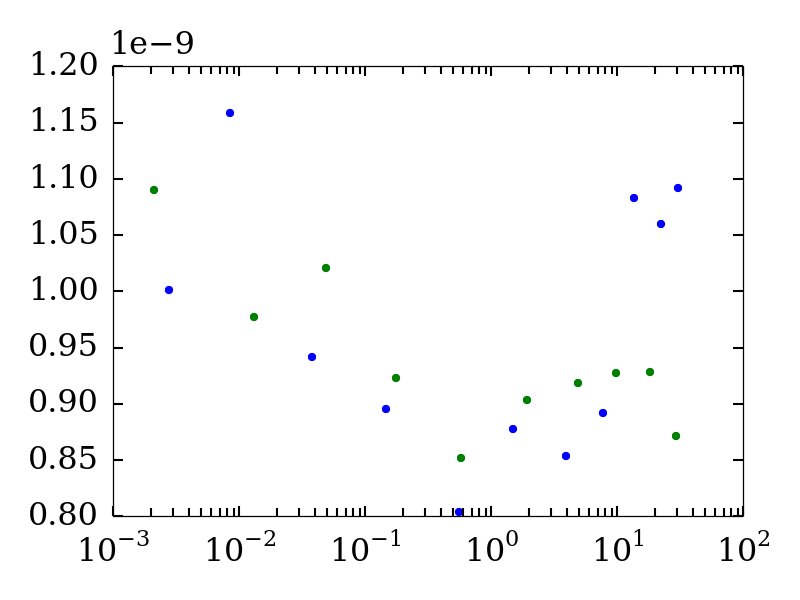

In [102]:
fig, ax = plt.subplots()

ax.plot(1e12 * bb.eta * bb.source_power,
        bb.d_S21_d_X**2 * bb['{}_amp'.format(bb_max_name)],
        '.')

ax.plot(1e12 * cw.eta * cw.source_power,
        cw.d_S21_d_X**2 * cw['{}_amp'.format(cw_max_name)],
        '.')

ax.set_xscale('log')

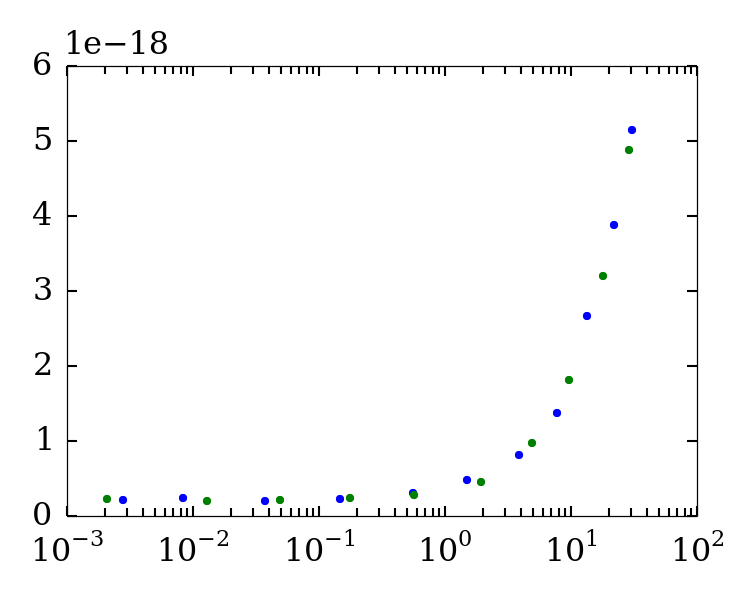

In [103]:
fig, ax = plt.subplots()

ax.plot(1e12 * bb.eta * bb.source_power,
        bb['{}_amp'.format(bb_max_name)],
        '.')

ax.plot(1e12 * cw.eta * cw.source_power,
        cw['{}_amp'.format(cw_max_name)],
        '.')

ax.set_xscale('log')

# Plotting

In [104]:
# Plot parameters
P_A_scale = 1e12
photon_color = 'red'
recombination_color = 'blue'
amp_color = 'gray'
TLS_color = 'brown'
device_color = 'green'
total_color = 'black'

# Comparison

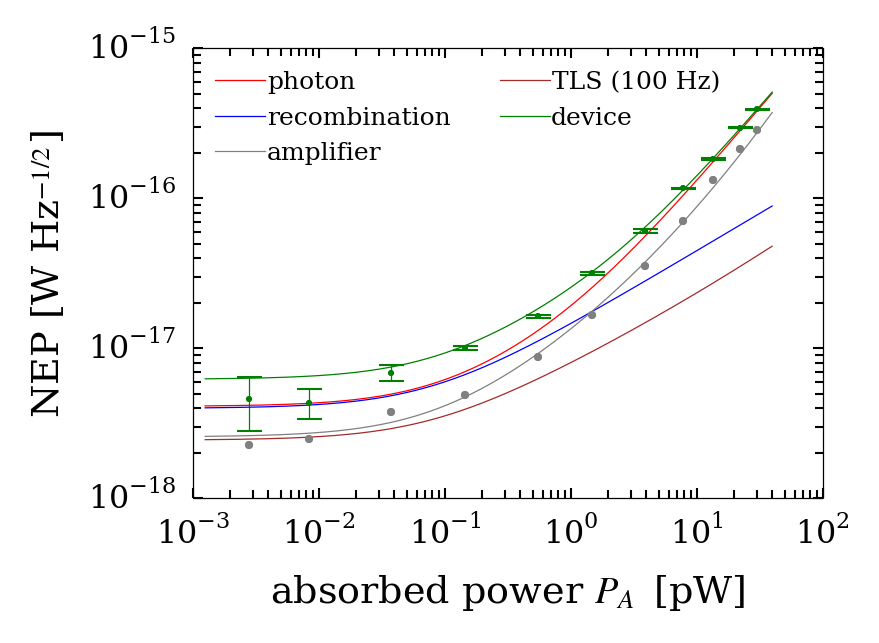

In [105]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('NEP [W Hz$^{-1/2}$]')

ax.plot(P_A_scale * P_A,
        photon**(1/2),
        color=photon_color, label='photon')

ax.plot(P_A_scale * P_A,
        recombination**(1/2),
        color=recombination_color, label='recombination')

ax.plot(P_A_scale * P_A,
        amplifier**(1/2),
        color=amp_color, label='amplifier')

ax.plot(P_A_scale * P_A,
        TLS**(1/2),
        color=TLS_color, label='TLS (100 Hz)')

ax.plot(P_A_scale * P_A,
        device**(1/2),
        color=device_color, label='device')

ax.errorbar(P_A_scale * bb.eta * bb.source_power,
            NEP_bb,
            yerr=NEP_bb_err,
            marker='.', markeredgecolor='none', linestyle='none',
            color=device_color)

ax.plot(P_A_scale * bb.eta * bb.source_power,
        bb.eta * bb.source_power_fd_NEP2_amplifier**(1/2),
        '.', color=amp_color)

ax.set_ylim(1e-18, 1e-15)
ax.legend(loc='upper left', fontsize=6, ncol=2);

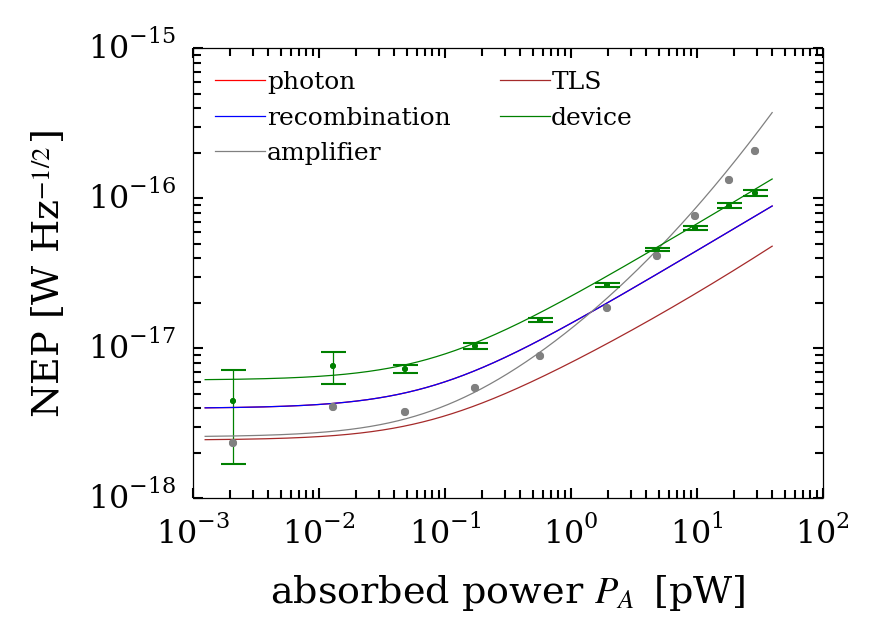

In [106]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('NEP [W Hz$^{-1/2}$]')

ax.plot(P_A_scale * P_A,
        kid.NEP2_photon_shot(Gamma=Gamma_A + Gamma_B, nu=nu_center)**(1/2),
        color=photon_color, label='photon')

ax.plot(P_A_scale * P_A,
        recombination**(1/2),
        color=recombination_color, label='recombination')

ax.plot(P_A_scale * P_A,
        amplifier**(1/2),
        color=amp_color, label='amplifier')

ax.plot(P_A_scale * P_A,
        TLS**(1/2),
        color=TLS_color, label='TLS')

ax.plot(P_A_scale * P_A,
        (2 * recombination + TLS)**(1/2),
        color=device_color, label='device')

ax.errorbar(P_A_scale * cw.eta * cw.source_power,
            NEP_cw,
            yerr=NEP_cw_err,
            marker='.', markeredgecolor='none', linestyle='none',
            color=device_color)

ax.plot(P_A_scale * cw.eta * cw.source_power,
        cw.eta * cw.source_power_fd_NEP2_amplifier**(1/2),
        '.', color=amp_color)

ax.set_ylim(1e-18, 1e-15)
ax.legend(loc='upper left', fontsize=6, ncol=2);

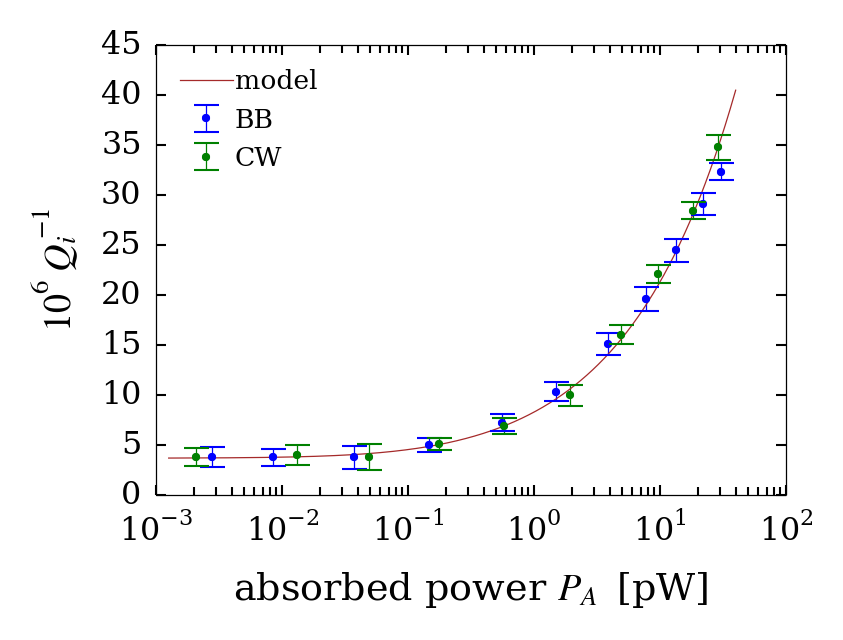

In [78]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('$10^6 Q_i^{-1}$')

ax.plot(P_A_scale * P_A,
        1e6 * kid.iQi(Gamma=Gamma),
        color='brown', label='model')

ax.errorbar(P_A_scale * bb.eta * bb.source_power,
            1e6 * bb.source_power_I,
            yerr=1e6 * bb.source_power_I_err,
            marker='.', linestyle='none', color='blue', label='BB')

ax.errorbar(P_A_scale * cw.eta * cw.source_power,
            1e6 * cw.source_power_I,
            yerr=1e6 * cw.source_power_I_err,
            marker='.', linestyle='none', color='green', label='CW')

ax.legend(loc='best', fontsize='xx-small');